# Imports

In [1]:
import numpy as np
import pandas as pd
# from src import pipeline
from src import common
from src.outlier_model import OutlierModel
import matplotlib.pyplot as plt

# Dataset preprocessing

In [2]:
column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
column_types = common.json_load(column_types_loc)

target = column_types["target"]
identifier = column_types["identifier"]
cat_cols = column_types["categorical"]
measurement_label = column_types["measurement_label"]

data = pd.read_pickle(
    f"#datasets/Colab_PowerConverter/dataset.pkl"
)

# this measurement did not have a fault (?)
data = data[data[measurement_label]!="Single-Phase_Sensor_Fault"]
data.reset_index(inplace=True, drop=True)

# assign unique label to each measurement fault and create dictionary for easier analysis
fault_dict = {}
for label,i in zip(data[measurement_label].unique(), range(len(data[measurement_label].unique()))):
    data.loc[(data[measurement_label]==label) & (data[target]==1), target] = int(i+1)
    fault_dict[label] = int(i+1)

data.drop(columns=[measurement_label], inplace=True)
# Fill NA - 0 for numerical and 'NA' for categorical
# categorical
data[cat_cols] = data[cat_cols].fillna("NA")
data[cat_cols] = data[cat_cols].astype(str)
# non-categorical
non_cat_cols = data.drop(columns=cat_cols + [identifier]).columns.tolist()
data[non_cat_cols] = data[non_cat_cols].fillna(0)


# Train model

In [3]:
# task = "multiclass"
#
# column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
# save_loc = "models.dill"
#
# parameters = {
#     "random_state": 1,
#     "test_size_train": 0.2,
#     "test_size_valid": 0.5,
#     "scaler": "Standard",
# }
#

In [4]:
# (
#     data_train_scaled,
#     data_valid_scaled,
#     data_test_scaled,
#     models,
# ) = pipeline.train(task,data, column_types_loc, parameters, save_loc=save_loc, verbose=True, datasets=True)
#

In [5]:
# predicted = pipeline.predict(data, column_types_loc, save_loc)

# Outlier_model
* outlier_model code that implementes outlier_model.predict() function

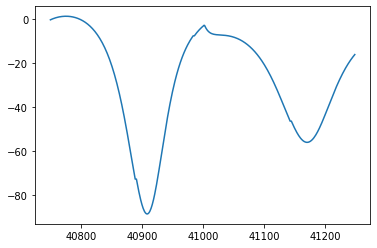

In [21]:
start_index = 0
end_index = 200000
data_test = data[start_index:end_index]
# data_test = data
# data_test.plot(subplots=True, figsize=(16,15))


outlier_key = "f_c"
m = 250
preload_size = 1000
plt.plot(data[40750:41250][outlier_key])
outlier_model = OutlierModel(m=m,std_dev=2,
                             time_series=data_test[:preload_size][outlier_key],
                             egress=True,
                             lag=4000,
                             influence=0.20,
                             threshold=15)


# Simulate stream of data
## Inverse transform test dataset for evaluation

In [7]:

# data_test = pd.DataFrame(models["scaler"].inverse_transform(data_test_scaled.drop(columns=cat_cols + [identifier,target])),
#                columns=data_test_scaled.drop(columns=cat_cols + [identifier,target]).columns.values)
# data_test[[identifier,target]] = data_test_scaled[[identifier,target]].copy()

In [8]:
data_test.head()

,f_c,P,m_d,m_q,theta,P_ref,V_DC,V_phaseA,V_phaseB,V_phaseC,I_phaseA,I_phaseB,I_phaseC,fault,sample_id
20000,0.976346,101067.904086,311.0,0.0,-326.277334,2500.0,800.0,135.825801,174.376728,-310.202528,-447.722740,980.379898,-532.657158,0,20000
20001,1.033455,100953.079827,311.0,0.0,-326.277027,2500.0,800.0,143.309545,167.379808,-310.689353,-441.669389,991.785643,-550.116254,0,20001
20002,1.085590,100848.256418,311.0,0.0,-326.276702,2500.0,800.0,150.614978,160.334393,-310.949370,-435.552265,1002.998657,-567.446392,0,20002
20003,1.132773,100753.390203,311.0,0.0,-326.276361,2500.0,800.0,157.731195,153.258082,-310.989277,-429.377636,1014.016023,-584.638387,0,20003
20004,1.175021,100668.445963,311.0,0.0,-326.276005,2500.0,800.0,164.648655,146.168266,-310.816921,-423.152049,1024.835401,-601.683352,0,20004


* loading the whole DL model with preprocessors in each iteration is stupid but I wanted to send Alex at least some initial code

In [22]:
fault = False
for index, row in data_test[preload_size:].iterrows():
    if index % 10000 == 0:
        print(f"Current Global index: {index}")
    if not fault:
        outlier_model.train_one(row[outlier_key])
        outlier_model.predict_one(index)
        # print("fault start")
    else:
        # predicted = pipeline.predict(row, column_types_loc, save_loc)
        print("fault continues")
        # if predicted == 0:
        #     fault = False
        #     print("fault ended")

Current Global index: 40000


12/03/2021 07:42:53 PM: 41003 max_mp value: 0.021 >comp: 0.016500233240022803
12/03/2021 07:42:53 PM:  Anomaly at Global index: 41003, local index: 750


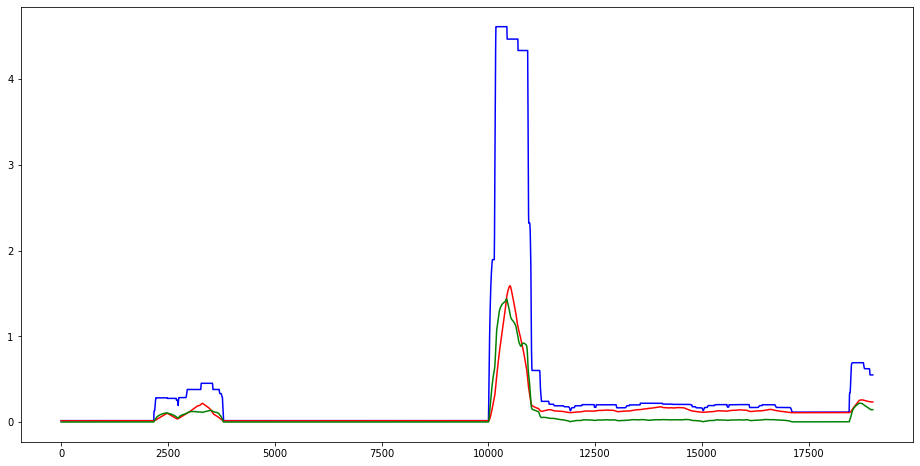

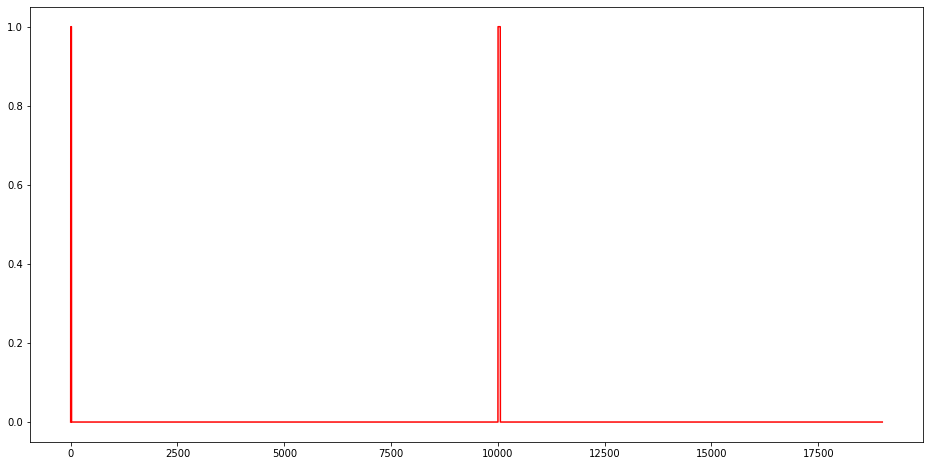

In [23]:
plt.figure(figsize=(16,8))

plt.plot(outlier_model.max_val,'b-',
         outlier_model.max_mean,'r-',
         outlier_model.max_std_dev,'g-')
# plt.plot(outlier_model.max_std_dev)
plt.figure(figsize=(16,8))
plt.plot(outlier_model.comparisson, 'r-')

# plt.figure(figsize=(16,8))
# plt.plot(data_test["fault"])
# plt.plot(data_test[outlier_key])

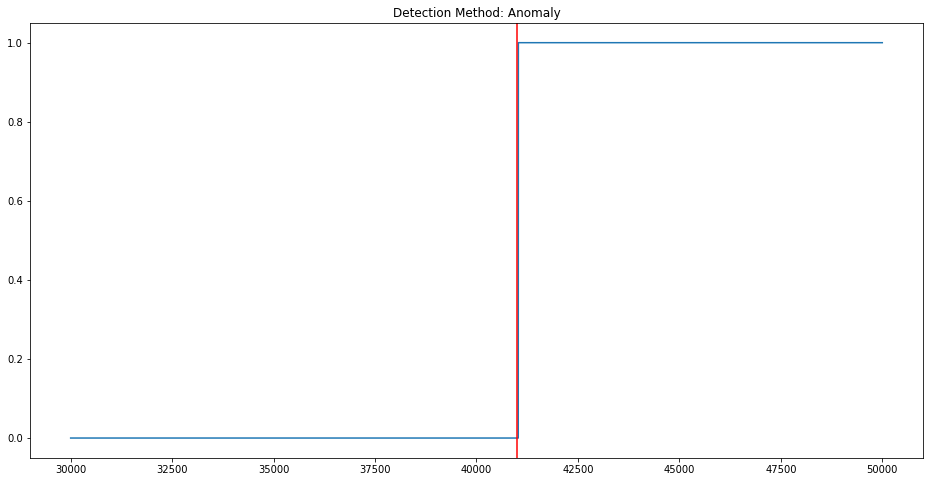

In [24]:
plt.figure(figsize=(16,8))
plt.plot(data_test["fault"])
plt.title(f"Detection Method: Anomaly")
for i in outlier_model.anomalies:
    plt.axvline(x=i,color='r')